# Mycoplasma Bovis analysis

Links

* https://www.ncbi.nlm.nih.gov/genome/browse/#!/prokaryotes/1150/

Bioprojects:

* Genomic epidemiology of Mycoplasma bovis in France: SRP386998
* Genome-Wide Identification of Variants Associated with Antimicrobial Resistance in Mycoplasma bovis: SRP349146/PRJNA785928
* Sanger Full_genome_sequencing_of_Mycoplasma_species_isolates_from_ruminants (Israel): PRJEB3408
* Mycoplasmopsis bovis Genome sequencing and assembly (China): PRJNA1021812
* WGS Australian Mycoplasma bovis isolates: PRJNA335520
* Comparative genomics of mycoplasma bovis: PRJNA602897 (DTU)
* Mycoplasma bovis genomes from the New Zealand outbreak: PRJNA664415
* De novo genome assembly of 36 Mycoplasma bovis strains: PRJNA954308

Refs:

* [Genomics-based epidemiology of bovine Mycoplasma bovis strains in Israel](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-020-6460-0#Sec13)
* [Population Genomic Analysis of Mycoplasma bovis Elucidates Geographical Variations and Genes associated with Host-Types](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7650767/)
* [Identification of Antimicrobial Resistance-Associated Genes through Whole Genome Sequencing of Mycoplasma bovis Isolates with Different Antimicrobial Resistances](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7400188/)

Ref strain:

* https://www.culturecollections.org.uk/nop/product/mycoplasma-bovis

In [743]:
import os,sys,subprocess,glob,re
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from importlib import reload
from snipgenie import app, tools, clustering, plotting
pd.options.display.max_rows = 200
pd.set_option('display.width', 1000)

In [758]:
cm = {'Ireland': "#4AA60E",
  'Scotland': "#74E600",
  'Germany' : "#007439",
  'Finland' : "#0969A2",
  'Poland' : "#FF8C00",
  'Netherlands' : "#03436A",
  'Lithuania' : "#B0F26D",  
  'New Zealand' : "#FF3D00",
  'Canada' : "#FF9473",
  'France' : "#A62800",
  'Russia' : "#E6E6E6",
  'Ethiopia' : "#FFC073",
  'Australia' : "#A65B00",
  'Israel' : "#CFA127",
  'Denmark': "#C029C5",
  'USA' : "#64A8D1"}

In [ ]:
#sra samples stats
srafiles = glob.glob('*_runTable.csv')
res=[]
for f in srafiles:
    df=pd.read_csv(f)
    res.append(df)
res=pd.concat(res)
res.geo_loc_name_country.value_counts()
#res[res.geo_loc_name_country=='

In [38]:
ref = 'NC_014760.fa'
refgb = 'NC_014760.gb'

In [732]:
samples=pd.read_csv('results/samples.csv',index_col=0)
meta=pd.read_csv('metadata.csv')
meta = meta[meta.status!='removed']

In [728]:
samples = samples.merge(meta,on='sample', how='left')

In [789]:
dm = pd.read_csv('results/snpdist.csv',index_col=0)

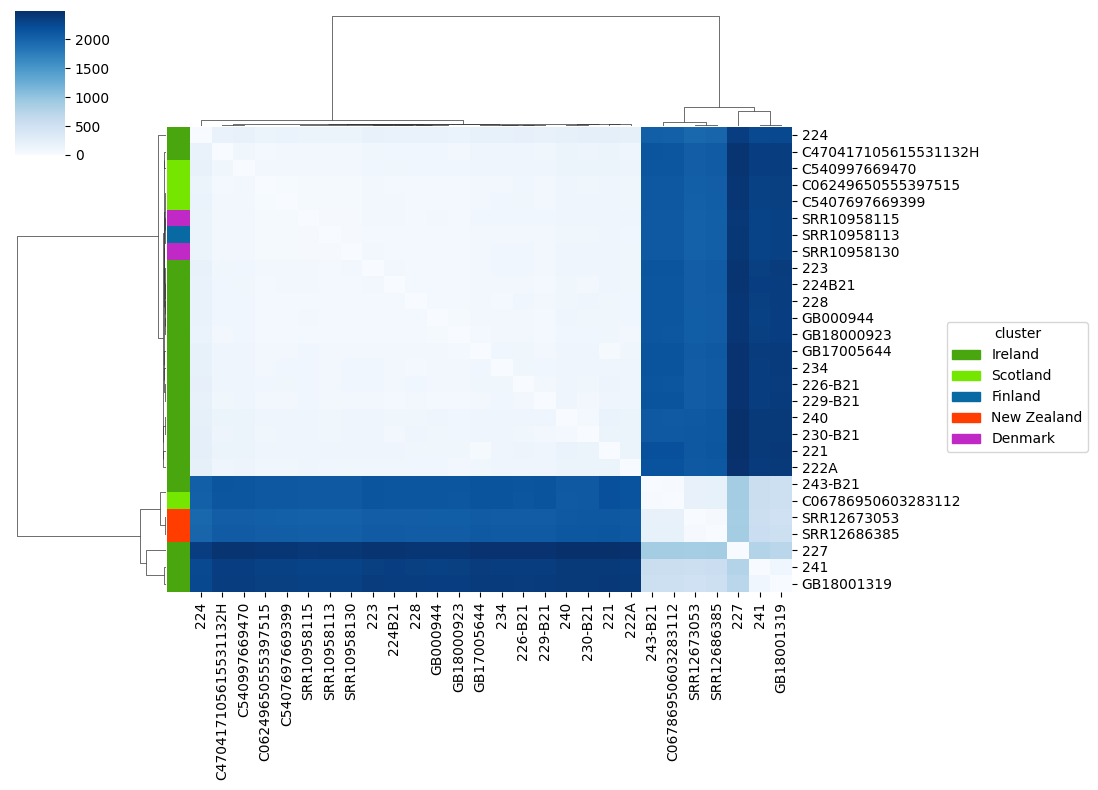

In [791]:
cm = {'Ireland': "#4AA60E",
  'Scotland': "#74E600",  
  'Finland' : "#0969A2", 
  'New Zealand' : "#FF3D00",  
  'Denmark': "#C029C5"
   }
sub = meta[meta.country.isin(['Ireland','Scotland','Denmark','Finland','New Zealand'])]
idx = sub['sample']
#rcolors,cm=plotting.get_color_mapping(sub,'country')
rcolors = list(sub.country.map(cm))
#print (rcolors) 
X = dm.loc[idx,idx]
cg=sns.clustermap(X, cmap='Blues', row_colors=rcolors, xticklabels=True, yticklabels=True, 
                  figsize=(10,8))#, annot=True, annot_kws={'size':7})#,fmt='.0f')
p=plotting.make_legend(cg.fig, cm, loc=(1.1, .6), title='cluster',fontsize=10)

In [186]:
#C=pd.read_csv('results/csq.matrix').T
csq = app.read_csq_file('results/csq.tsv')
aamat = app.get_aa_snp_matrix(csq)

## check duplicates

In [ ]:
for pair,df in samples.groupby('pair'):
    if len(df) == 1:
        continue        
    print (pair)
    #print (df)
    x=list(df['sample'])        
    print (dm.loc[x,x])

In [ ]:
tools.get_unique_snps(['227A'],aamat)

## deletions

In [9]:
from snipgenie import rdiff
sub=samples.sample(10,random_state=2)
regions = rdiff.get_deletions(samples, ref, refgb, #mask_file=app.mbovis_mask,
                              label='sample', min_coverage=0, n_cores=12)
regions.to_csv('deletion_regions.csv',index=False)

In [ ]:
regions = pd.read_csv('deletion_regions.csv')
res=regions[regions.length>2000]
X=pd.pivot_table(res,index=['group','genes'],columns='name',values='length').fillna(0)
X=X.clip(0,1)
X=X.droplevel(1)

sns.clustermap(X,cmap='Blues',yticklabels=True,row_cluster=False,lw=.4,linecolor='.8',figsize=(14,10))

#write a mask file?
#X

In [ ]:
s=590804;e=s+1000
rdiff.show_coverage(samples, 'NC_014760.1',s,e,ref,refgb,margin=1300)

## assembly

In [ ]:
for i,r in samples.iterrows():    
    name = r['sample']
    print (name)
    if name in ['pure']: continue
    tools.spades(r.filename1,r.filename2, os.path.join('assembly',name), 'assembly/%s.fa' %name, 12)

## annotation

In [ ]:
out='annot'
files = glob.glob('assembled/*.fa')
a = [os.path.basename(i) for i in files]
trusted = 'CP002188.gb'

for f in files:
    n = os.path.splitext(os.path.basename(f))[0]
    cmd = '/local/prokka/bin/prokka --proteins {p} --outdir {o}/{n} {f} --prefix {n}'.format(p=trusted,f=f,n=n,o=out)#,p=path)    
    if not os.path.exists('%s/%s' %(out,n)):
        print (cmd)
        subprocess.check_output(cmd, shell=True)

In [238]:
files = glob.glob('annot/**/*.gff',recursive=True)
import shutil
for f in files:   
    shutil.copy(f, os.path.join('gff_annot',os.path.basename(f)))
    

## roary

In [87]:
def get_presence_absence(df, cols=None):
    """parse roary file"""
    if cols is None:
        cols = df.columns[14:]
    x=df.copy()
    x['cat'] = x.Annotation.apply(lambda x: apply_cat(x))
    x = x.set_index(['cat','Gene','Annotation'])
    x = x[cols].notnull().astype('int')
    #x = x.loc[x.index.dropna()]
    return x

def apply_cat(x):
    keys=['ARO','efflux','adhesin','LEE','porin','stress',
          'secretion system', 'bacteriophage',
          'membrane','prophage','secreted','IS','insertion','transposase','integrase',
          'virulence','protease','stress','toxic','phage','kinase','phosphatase',
          'hypothetical','membrane','binding','rna','ribosomal','tRNA','methyltransferase',
         'polymerase','DNA','Transcription','lipoprotein','protease']
    for i in keys:
        if x is np.nan: return
        if i in x:
            return i
    return 'other'
    
def genes_clustermap(x,xticklabels=0,title=''):    
    """plot cluster map of genes"""
    from matplotlib.colors import ListedColormap, LogNorm
    #x = x[x.sum(1)>=1]
    sys.setrecursionlimit(20000)
    clrs = ["lightgray", "black"]
    t_cmap = ListedColormap(sns.color_palette(clrs).as_hex())
    if len(x)>50:
        yticklabels=0
    if len(x.T)>50:
        xticklabels=0
    cg=sns.clustermap(x,xticklabels=xticklabels,yticklabels=1,cmap=t_cmap,figsize=(12,7))
    cg.fig.suptitle(title)
    cg.fig.subplots_adjust(right=0.8)
    return

In [ ]:
cmd = 'roary -f roary_out -e -n -v -z -s -i 85 -cd 90 -p 12 gff_annot/*.gff'
subprocess.check_output(cmd, shell=True)

In [342]:
roary = pd.read_csv('roary_out/gene_presence_absence.csv')
R = get_presence_absence(roary)

In [ ]:
genes_clustermap(R.T)

In [ ]:
R.reset_index().cat.unique()
x=R.loc['lipoprotein',:,:].sum(1)
x=R.reset_index()
x[x.Annotation.str.contains('Vsp')]

In [ ]:
f=R[(R.sum(1)>=44)]
f.reset_index().cat.unique()
f.loc['ribosomal',:,:].sum(1)

In [ ]:
genes=['vspJ','vspB','vspA','vspH','vspE','vspF','vspG']
#v=R.loc[:,'vspJ',:]
#f,ax=plt.subplots(1,1,figsize=(10,10))
sns.clustermap(v,xticklabels=True,figsize=(10,7),palette='Blues')


## VSP genes

In [714]:
def find_genes(target, query, ident=90, coverage=75, duplicates=False, threads=2, **kwds):
    """Find ref genes by blasting the target sequences"""

    from Bio.SeqRecord import SeqRecord
    from Bio.Seq import Seq
    from Bio import SeqIO

    queryseqs = list(SeqIO.parse(query,'fasta'))
    print ('blasting %s sequences' %len(queryseqs))
    bl = tools.blast_sequences(target, queryseqs, maxseqs=1, evalue=1e-4,
                               cmd='blastn', show_cmd=True, threads=int(threads))

    #print (bl.iloc[0])
    bl['qlength'] = bl.qseq.str.len()
    bl['coverage'] = bl.length/bl.qlength*100
    bl = bl[bl.coverage>coverage]
    bl = bl[bl.pident>ident]
    bl['filename'] = bl.sseqid.apply(lambda x: x.split('~')[0],1)
    bl['id'] = bl.filename.apply(lambda x: os.path.basename(x),1)
    bl['contig'] = bl.sseqid.apply(lambda x: x.split('_')[1],1)
    try:
        bl['gene'] = bl['qseqid'].apply(lambda x: x.split('~~~')[1],1)
    except:
        bl['gene'] = bl.qseqid

    #remove exact and close duplicates
    print (len(bl))
    bl = bl.sort_values(['bitscore'], ascending=False).drop_duplicates(['contig','sstart','send'])
    print (len(bl))
    if duplicates == False:
        dist = 20
        x=bl.sort_values(by=["contig","sstart"],ascending=False)
        #print (x[:15][x.columns[:5]])
        unique = x.sstart.diff().abs().fillna(dist)
        bl = bl[unique>=dist]
    cols = ['gene','id','qseqid','pident','coverage','sstart','send','contig','filename','bitscore']
    #print (bl)
    bl = bl[cols]
    return bl

In [ ]:
#blast to vsp genes directly
blastres=[]
for i,r in samples[:2].iterrows():
    name = r['sample']
    target = 'assembled/%s.fa' %name
    if not os.path.exists(target): continue
    print (target)
    tools.make_blast_database(target,dbtype='nucl')
    bl = find_genes(target,'vsp.fa',ident=95,coverage=95)
    bl['sample'] = name
    blastres.append(bl)
blastres = pd.concat(blastres)

In [ ]:
#x = bl.drop_duplicates(['sstart'])
m = pd.pivot_table(blastres, index='sample', columns='gene', values='pident').fillna(0)
m[m>0] = 1
sns.clustermap(m, yticklabels=True,figsize=(10,9), cmap='Reds')

In [348]:
xx=meta.merge(m,on='sample')
xx.to_csv('metadata_all.csv',index=False)

## AMR/virulence gene detection

## AMR SNPs

In [ ]:
C=pd.read_csv('results/csq.matrix')
C.snp_type.value_counts()

In [ ]:
S=C[C.snp_type=='stop_lost']
S

In [ ]:
M=C[C.snp_type=='missense']
freq = M.iloc[:,4:].sum(axis=1)
M=M[freq>4]
M=C[C.snp_type=='stop_lost']

In [ ]:
X=C.iloc[:,4:]
#colors,colormap=plotting.get_color_mapping(C,county1',cmap='Set1')
cg = sns.clustermap(X,xticklabels=False,yticklabels=False,cmap='gray_r',cbar_pos=None,figsize=(17,10)) #row_colors=[colors1,colors2]


## coverage

In [ ]:
reload(tools)
n=8
fig,ax=plt.subplots(n-1,1,figsize=(25,12))
axs=ax.flat
i=0
for idx,r in df.sample(n).iterrows(): 
    #print (r.bam_file)
    if pd.isnull(r.bam_file): continue   
    d=tools.samtools_depth(r.bam_file, start=180000,end=300000)
    x=groupby_interval(d,500,1000)
    ax=axs[i]
    x.plot(kind='area',ax=ax)
    label = r['sample']
    ax.text(.05,.8,label,color='blue',transform=ax.transAxes,fontsize=12)
    ax.set_xticklabels([])
    i+=1
sns.despine()
plt.tight_layout()

In [5]:
def groupby_interval(df, clip=2, interval=100):
    """Group over an interval - used for samtools depth data"""
    
    min = df.pos.min()
    max=df.pos.max()
    b = np.arange(min, max, interval)
    #rint (b)
    x=df.groupby(pd.cut(df.pos, bins=b, labels=b[:-1], right=False)).mean(numeric_only=True)['depth']
    x = x.clip(0,clip)
    x = x.replace(0,np.nan)
    return x.dropna()

In [ ]:
d=tools.samtools_depth('results/mapped/222A.bam')
data=groupby_interval(d,500,1000).dropna()
data

In [ ]:
from pycirclize import Circos
from pycirclize.parser import Genbank
from pycirclize.utils import load_prokaryote_example_file
import numpy as np
from matplotlib.patches import Patch

# Load Genbank file
gbk_file = 'NC_014760.gb'
gbk = Genbank(gbk_file)

circos = Circos(sectors={gbk.name: gbk.range_size}, start=0, end=320)
sector = circos.get_sector(gbk.name)
major_ticks_interval = 200000
minor_ticks_interval = 50000
outer_track = sector.add_track((98, 100))
outer_track.axis(fc="lightgrey")
outer_track.xticks_by_interval(
    major_ticks_interval, label_formatter=lambda v: f"{v/ 10 ** 6:.1f} Mb"
)
outer_track.xticks_by_interval(minor_ticks_interval, tick_length=1, show_label=False)

f_cds_track = sector.add_track((90, 97), r_pad_ratio=0.1)
f_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=1), fc="red")
r_cds_track = sector.add_track((83, 90), r_pad_ratio=0.1)
r_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=-1), fc="blue")

n=8
i=70
h=6
text_common_kws = dict(ha="right", va="center", size=8)
for idx,r in df.sample(n).iterrows(): 
    name = r['sample']
    if pd.isnull(r.bam_file): continue   
    d = tools.samtools_depth(r.bam_file)#, start=200000,end=350000)
    data = groupby_interval(d,500,2000)
    x=data.index
    y=data.values
    track = sector.add_track((i, i+h), r_pad_ratio=0.1)
    track.axis()
    #track.line(x, y)
    track.fill_between(x, y, ec="black", lw=.2)
    i-=h
    circos.text(name, r=i+h+2, color="black", **text_common_kws)

fig = circos.plotfig(160)

In [ ]:
from pycirclize import Circos
from io import StringIO
from Bio import Phylo
import numpy as np

np.random.seed(0)

tree = Phylo.read('results/tree.newick', "newick")
leaf_num = tree.count_terminals()

# Initialize circos sector with tree size
circos = Circos(sectors={"Tree": leaf_num}, start=-350, end=0)
sector = circos.sectors[0]

# Plot tree
tree_track = sector.add_track((30, 80))
tree_track.tree(
    tree,
    use_branch_length=True, 
    leaf_label_size=10,
    leaf_label_margin=2, # Set large margin for heatmap plot
    
)

# Plot heatmap
heatmap_track = sector.add_track((100, 120))
matrix_data = np.random.randint(0, 100, (5, leaf_num))
heatmap_track.heatmap(matrix_data, cmap="viridis")
heatmap_track.yticks([0.5, 1.5, 2.5, 3.5, 4.5], list("ABCDE"), vmax=5, tick_length=0)

fig = circos.plotfig()


## kraken

In [ ]:
reload(tools)
f1 = '/storage/catherine/data/222A_S3_L001-4_R1_001.fastq.gz'
f2 = '/storage/catherine/data/222A_S3_L001-4_R2_001.fastq.gz'
rep=tools.kraken(f1, f2, threads=8)

In [ ]:
res=[]
found = pd.read_csv('/storage/catherine/contam_kraken.csv')
samples = pd.read_csv('/storage/catherine/results/samples.csv')

for i,r in samples.iterrows():
    name = r['sample']
    print (name)
    if name in list(found['sample']):
        continue
    rep = tools.kraken(r.filename1,r.filename2, threads=8)    
    rep=rep[rep.perc_frag>0.1]    
    rep['sample'] = name
    res.append(rep)
if len(res)>0:
    df=pd.concat(res)
    found = pd.concat([found,df])
    #found = df
    found.to_csv('/other/catherine/contam_kraken.csv',index=False)

In [ ]:
found = pd.read_csv('/other/catherine/contam_kraken.csv')
x=found[found.rank_code=='S']
contam = x.pivot_table(index='sample',columns='name',values='perc_frag').fillna(0)
ax=plt.subplots(1,1,figsize=(12,6))
sns.heatmap(contam,lw=1,cmap='Blues',annot=True,yticklabels=True)

## kSNP commands

```
/local/kSNP4.1/MakeKSNP4infile -indir entrez_assemblies/ -outfile entrez_genomes.txt
/local/kSNP4.1/kSNP4 -core -k 31 -outdir ksnp_assembled -in assembled_genomes.txt
```

In [ ]:
def get_assembly_summary(id):
    """Get esummary for an entrez id"""
    
    from Bio import Entrez
    esummary_handle = Entrez.esummary(db="assembly", id=id, report="full")
    esummary_record = Entrez.read(esummary_handle)
    return esummary_record


def get_assemblies(term):
    """Download genbank assembly meta data for a given search term.
    Args:
        term: search term, usually organism name        
    """

    from Bio import Entrez
    from tqdm import tqdm
    #provide your own mail here
    Entrez.email = "A.N.Other@example.com"
    handle = Entrez.esearch(db="assembly", term=term, retmax='5000')
    record = Entrez.read(handle)
    ids = record['IdList']
    print (f'found {len(ids)} ids')
    links = []
    result = []
    for id in tqdm(ids):
        row = {'id':id}
        #get summary
        rec = get_assembly_summary(id)
        #print (id)        
        asm_summ = rec['DocumentSummarySet']['DocumentSummary'][0]       
        fields = ['AssemblyAccession','BioSampleAccn','BioSampleId','SubmitterOrganization']
        for key in fields:
            row[key] = asm_summ[key]
        row['GenbankAccession'] = asm_summ['Synonym']['Genbank']
        
        #biosample info is a separate request using the BioSampleId
        handle = Entrez.esummary(db="biosample", id=asm_summ['BioSampleId'], report="full")        
        rec2 = Entrez.read(handle)
        sampledata = rec2['DocumentSummarySet']['DocumentSummary'][0]['SampleData']
        #parse xml in sampledata
        from bs4 import BeautifulSoup
        soup = BeautifulSoup(sampledata)
        all_attr = soup.findAll('attribute')        
        for attr in all_attr:
            #print (attr,attr['attribute_name'],attr.text)
            row[attr['attribute_name']] = attr.text
        #get url
        #url = asm_summ['FtpPath_RefSeq']
        url = asm_summ['FtpPath_GenBank']
        #print (url)
        if url != '':           
            label = os.path.basename(url)
            #get the fasta link - change this to get other formats
            link = os.path.join(url,label+'.fna.gz')        
            row['link'] = link
        result.append(row)
    result = pd.DataFrame(result)
    return result

def download_links(df, path):
    for i,r in df.iterrows():
        label = r.AssemblyAccession
        urllib.request.urlretrieve(link, os.path.join(path, f'{label}.fna.gz'))
        
res = get_assemblies('Mycoplasmopsis bovis')

In [ ]:
#temp=get_assemblies('Mycoplasmopsis bovis')

In [567]:
def func(x):
    return re.sub(r'\.(1|2)', '', x)

res['name'] = res.GenbankAccession.apply(func,1)
res['country'] = res.geo_loc_name.fillna('').apply(lambda x: x.split(':')[0])
res=res.drop_duplicates('name')
res=res.set_index('name')

/tmp/ipykernel_248744/2184058754.py:4: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  res['name'] = res.GenbankAccession.apply(func,1)


In [569]:
res.to_csv('assembly_details.csv')

In [ ]:
files=glob.glob('entrez_assemblies/*')
for f in files:
    new = os.path.basename(f).split('_ASM')[0]+'.fna'
    print (new)
    shutil.move(f, os.path.join('entrez_assemblies',new))    

In [631]:
final=pd.concat([res,meta.set_index('sample')])
def get_region(x):
    if x in ['UK','France','Belgium','Lithuania','Russia','Hungary','Netherlands','Denmark','Finland','Austria','Germany','Poland','Romania']:
        return 'Europe'
    return x
final['region'] = final.country.apply(get_region)

In [632]:
res.host.unique()
def get_species(x):
    if x in ['Bos taurus','calf','cattle','bovine','yak','Cow']:
        return 'Cow'
    if x in ['bison','Bison bison']:
        return 'Bison'
    elif x in ['mule deer','white tail deer','Odocoileus hemionus']:
        return 'Deer'
    else: return x
    
final['species'] = final.host.apply(get_species)

In [ ]:
njdm = pd.read_csv('ksnp_entrez/NJ.dist.matrix', sep='\s+').reset_index().set_index('level_0')
njdm.columns = list(njdm.index)
#njdm.to_csv('ksnp_entez/njdm.csv',index=True)

In [634]:
cl,memb=clustering.get_cluster_levels(njdm, levels=[3,7,12,20,40])

In [635]:
final = final.merge(cl, left_index=True, right_index=True)

In [707]:
final['year'] = pd.to_datetime(final.collection_date,format='mixed',errors='coerce',yearfirst=True).dt.year

In [709]:
final.to_csv('assembly_details.csv')

In [686]:
#reduced redundancy samples + ours
reduced = clustering.nonredundant_samples(cl, col='snp3')
keep = samples[:29]['sample']
reduced = pd.concat([reduced,cl.loc[keep]])
reduced = reduced[~reduced.index.duplicated(keep='last')]
reduced.to_csv('assembly_reduced.csv')
len(reduced)

128

In [687]:
#make reduced ksnp file
lines=''
for i,r in reduced.iterrows():    
    s= '/other/catherine/entrez_assemblies/{i}.fna\t{i}\n'.format(i=i)
    lines+=s    
#with open('reduced_genomes.txt', 'w') as f:
#    f.write(lines)